100%|██████████| 9.91M/9.91M [00:00<00:00, 54.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.60MB/s]


Client 3 Round 1 - Accuracy: 0.8534, Loss: 0.4742, Reputation: 0.75
Client 0 Round 1 - Accuracy: 0.8011, Loss: 0.6443, Reputation: 0.75
Client 1 Round 1 - Accuracy: 0.8327, Loss: 0.5381, Reputation: 0.75
Client 7 Round 1 - Accuracy: 0.8186, Loss: 0.6060, Reputation: 0.75
Client 9 Round 1 - Accuracy: 0.8737, Loss: 0.4303, Reputation: 0.75
Client 2 Round 1 - Accuracy: 0.8367, Loss: 0.5054, Reputation: 0.75
Client 4 Round 1 - Accuracy: 0.8768, Loss: 0.4220, Reputation: 0.75
Client 8 Round 1 - Accuracy: 0.8851, Loss: 0.3939, Reputation: 0.75
Client 6 Round 1 - Accuracy: 0.8764, Loss: 0.4261, Reputation: 0.75
Client 5 Round 1 - Accuracy: 0.8689, Loss: 0.4526, Reputation: 0.75
Client 3 Round 2 - Accuracy: 0.7719, Loss: 0.7254, Reputation: 0.80
Client 0 Round 2 - Accuracy: 0.8613, Loss: 0.4412, Reputation: 0.80
Client 1 Round 2 - Accuracy: 0.8654, Loss: 0.4512, Reputation: 0.80
Client 7 Round 2 - Accuracy: 0.8944, Loss: 0.3797, Reputation: 0.80
Client 9 Round 2 - Accuracy: 0.8957, Loss: 0.343

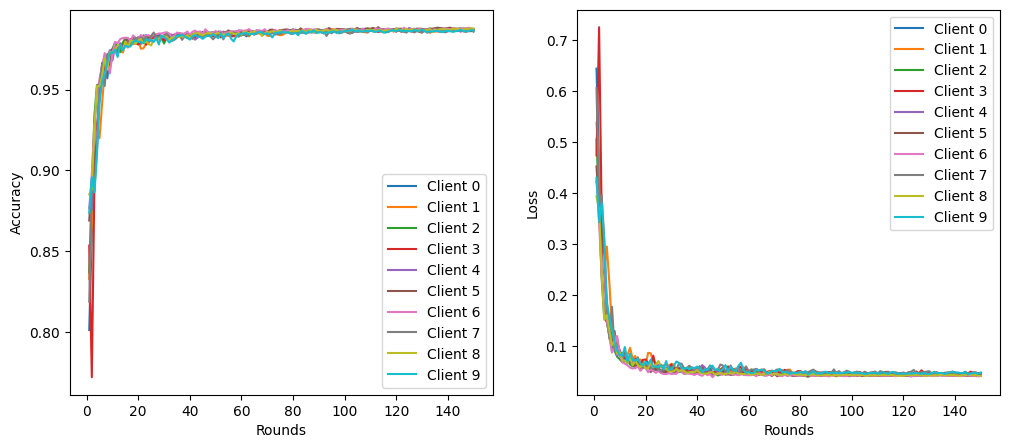

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import threading
import random
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
random.seed(42)
numpy_rng = np.random.default_rng(42)

# Define the FedProx model
class FedProxNet(torch.nn.Module):
    def __init__(self):  # <-- FIXED
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(128 * 14 * 14, 10)  # MNIST has 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.flatten(x)
        return self.fc(x)

# Define the Client class
class Client:
    def __init__(self, client_id, dataset, shared_memory, timestamps, neighbor_dict, mu=0.01):  # <-- FIXED
        self.client_id = client_id
        self.dataset = dataset
        self.shared_memory = shared_memory
        self.timestamps = timestamps
        self.neighbor_dict = neighbor_dict
        self.mu = mu  # Proximal term coefficient
        self.history = []
        self.memory_lock = threading.Lock()
        self.reputation = 0.7  # Initial reputation score

    def update_reputation(self, prev_loss, new_loss):
        if new_loss < prev_loss:
            self.reputation = min(1.0, self.reputation + 0.05)  # Increase reputation
        else:
            self.reputation = max(0.0, self.reputation - 0.1)  # Decrease reputation
        return self.reputation

    def train(self, global_parameters, lr):
        net = FedProxNet().to(device)
        global_parameters = {k: v.to(device) for k, v in global_parameters.items()}
        net.load_state_dict(global_parameters)

        optimizer = optim.SGD(net.parameters(), lr=lr)
        dataloader = DataLoader(self.dataset, batch_size=64, shuffle=True)

        global_params = {name: param.clone().detach().to(device) for name, param in global_parameters.items()}

        prev_loss = float('inf')
        for _ in range(3):  # Local epochs
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels)
                prox_term = sum((torch.norm(param - global_params[name].to(device)) ** 2 for name, param in net.named_parameters()))
                loss += (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()

        accuracy, new_loss = self.get_metrics(net)
        self.update_reputation(prev_loss, new_loss)  # Update reputation score
        return net.state_dict(), net

    def get_metrics(self, net):
        dataloader = DataLoader(dev_dataset, batch_size=64)
        correct, total = 0, 0
        total_loss = 0.0

        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = F.cross_entropy(outputs, labels, reduction='sum')
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        avg_loss = total_loss / total

        if len(self.history) == 0 or self.history[-1] != (accuracy, avg_loss):
            self.history.append((accuracy, avg_loss))

        return accuracy, avg_loss

num_clients = 10
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = [Subset(train_dataset, range(i, len(train_dataset), num_clients)) for i in range(num_clients)], test_dataset
shared_memory = {}
global_model = FedProxNet().to(device).state_dict()
for i in range(num_clients):
    shared_memory[i] = global_model

timestamps = {i: 0 for i in range(num_clients)}
neighbor_dict = {i: [] for i in range(num_clients)}
clients = [Client(i, train_dataset[i], shared_memory, timestamps, neighbor_dict) for i in range(num_clients)]

def train_asynchronously(client_id, client, max_rounds, base_lr):
    lr = base_lr
    for round_num in range(max_rounds):
        if client.reputation < 0.3:
            print(f"Client {client_id} removed due to low reputation ({client.reputation:.2f})")
            return

        neighbors = random.sample(range(num_clients), random.randint(1, num_clients - 1))
        client.neighbor_dict[client_id] = neighbors
        available_params = [client.shared_memory[neighbor] for neighbor in neighbors if neighbor in client.shared_memory]
        aggregated_params = available_params[0] if available_params else FedProxNet().to(device).state_dict()

        updated_params, net = client.train(aggregated_params, lr)
        client.shared_memory[client_id] = updated_params
        accuracy, loss = client.get_metrics(net)
        print(f"Client {client_id} Round {round_num + 1} - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}, Reputation: {client.reputation:.2f}")

        if (round_num + 1) % 5 == 0:
            lr *= 0.9

threads = [threading.Thread(target=train_asynchronously, args=(i, client, 150, 0.02)) for i, client in enumerate(clients)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

def plot_combined_metrics(clients):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[0] for entry in client.history], label=f'Client {client.client_id}')
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    for client in clients:
        plt.plot(range(1, len(client.history) + 1), [entry[1] for entry in client.history], label=f'Client {client.client_id}')
    plt.xlabel('Rounds')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_combined_metrics(clients)